<a href="https://colab.research.google.com/github/johnmot/DataAnalysisProjects/blob/main/Credit_Card_Fraud_Detection(johnmot.ver).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
!pip install pandas-bokeh # plotting tool for Pandas
# !conda install -c patrikhlobil pandas-bokeh
import pandas_bokeh

!pip install https://github.com/pandas-profiling/pandas-profiling/archive/master.zip 
from pandas_profiling import ProfileReport

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, plot_roc_curve, precision_recall_curve, confusion_matrix

import tensorflow as tf
from keras import models, layers, optimizers, initializers, metrics, losses #, regularizers

     / 55.7MB 768kB/s
     |████████████████████████████████| 81kB 4.4MB/s 
     |████████████████████████████████| 604kB 7.9MB/s 
     |████████████████████████████████| 3.1MB 16.7MB/s 
     |████████████████████████████████| 71kB 8.2MB/s 
     |████████████████████████████████| 296kB 46.0MB/s 
  Created wheel for pandas-profiling: filename=pandas_profiling-2.10.0-py2.py3-none-any.whl size=232425 sha256=9b28718bf008325121482b6fd81bdd38006a17f54b6f10ec5743de37fecbb109
  Stored in directory: /tmp/pip-ephem-wheel-cache-om7687md/wheels/56/c2/dd/8d945b0443c35df7d5f62fa9e9ae105a2d8b286302b92e0109
  Created wheel for htmlmin: filename=htmlmin-0.1.12-cp36-none-any.whl size=27085 sha256=d71414f60a8894dd2d2e1cb69869b6b184e6569747e2abd8e5f2c5427548e9a4
  Stored in directory: /root/.cache/pip/wheels/43/07/ac/7c5a9d708d65247ac1f94066cf1db075540b85716c30255459
Successfully built pandas-profiling htmlmin
  Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully unin

In [16]:
from google.colab import files
uploaded = files.upload()

Saving creditcard.csv to creditcard.csv


In [23]:
import io
import pandas as pd
data = pd.read_csv(io.BytesIO(uploaded['creditcard.csv']))
data.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [25]:
df = data
prof = ProfileReport(df)


In [ ]:
prof

Summarize dataset:   0%|          | 0/45 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [27]:
prof.to_file(output_file='report.html')

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [29]:
files.download('report.html')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [30]:
df.head(10)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,-0.371407,1.341262,0.359894,-0.358091,-0.137134,0.517617,0.401726,-0.058133,0.068653,-0.033194,0.084968,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,-0.099254,-1.416907,-0.153826,-0.751063,0.167372,0.050144,-0.443587,0.002821,-0.611987,-0.045575,-0.219633,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,1.249376,-0.619468,0.291474,1.757964,-1.323865,0.686133,-0.076127,-1.222127,-0.358222,0.324505,-0.156742,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,-0.410430,-0.705117,-0.110452,-0.286254,0.074355,-0.328783,-0.210077,-0.499768,0.118765,0.570328,0.052736,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,-0.366846,1.017614,0.836390,1.006844,-0.443523,0.150219,0.739453,-0.540980,0.476677,0.451773,0.203711,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


In [38]:
#전처리
# 금액(amount)의 분포가 너무 고르지 못하다.
# 따라서 로그처리를 통해 균등하게 통일시켜본다. 단, 값이 0이면 로그를 못취하니까 아주 작은 수를 넣어준다. 0.00001
df['Amount_logprice'] = np.log(df['Amount']+0.00001)
df['Amount_logprice'].describe() # 이 결과 -11.5~10.15 사이의 값들로 분포되었으며 표준편차는 2.2로 변환되었다. 

count    284807.000000
mean          2.912116
std           2.194647
min         -11.512925
25%           1.722768
50%           3.091043
75%           4.345946
max          10.153902
Name: Amount_logprice, dtype: float64

In [40]:
#독립,종속변수 나누는 함수
def Split(df):
  x = df.drop(['Time','Amount','Class'], axis=1)
  y = df['Class']
  return x,y

#데이터 분할
train_df, test_df=train_test_split(df, test_size=0.18, stratify=df['Class'])
train_df, val_df=train_test_split(train_df, test_size=0.22, stratify=train_df['Class'])

#데이터 할당

x_train, y_train = Split(train_df)
x_val, y_val = Split(val_df)
x_test, y_test = Split(test_df)



In [48]:
x_train

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount_logprice
276030,1.825684,-0.753086,-0.404848,0.344639,-0.685077,0.127175,-0.762152,0.194656,1.066801,0.155372,0.637752,0.728521,-0.465791,0.047327,-0.243866,0.563849,-0.709591,0.593388,0.002828,-0.054452,0.242926,0.674564,0.141568,0.809563,-0.340164,0.507508,-0.043760,-0.039248,4.317355
206241,2.063158,-1.798959,-1.058063,-1.208079,-1.208928,-0.168903,-0.926244,-0.159914,-0.788457,1.277507,-1.556490,-0.202671,0.651576,-0.950038,-2.088242,-1.374559,1.103696,-0.810583,0.591637,-0.191031,-0.465802,-0.855238,0.227811,0.655985,-0.159034,-0.364586,0.000074,-0.026342,4.859812
16871,1.223368,0.023293,0.421189,0.645042,-0.350041,-0.206032,-0.154746,0.046738,0.262213,-0.014801,0.703356,0.932768,-0.294597,0.151745,-0.862804,0.019422,-0.325015,-0.084434,0.635079,-0.124689,-0.208119,-0.449150,-0.031893,0.041268,0.462217,0.273039,-0.027003,-0.002041,0.000010
217170,-1.070094,1.765341,-0.831158,0.802907,0.839363,0.052580,0.314216,0.736680,-0.660500,-0.357208,0.370317,0.040371,-0.876365,-0.229449,-0.223140,0.234499,0.734495,0.963676,1.008132,-0.110130,-0.180893,-0.526323,0.095371,0.036800,-0.494744,-0.852742,-0.194584,-0.084257,0.518800
50230,0.672469,-0.254479,0.409848,2.402484,0.624714,2.350051,-0.189829,0.678533,-0.642490,0.443855,1.495725,1.207352,-0.029540,0.237782,-0.290918,-0.782429,0.624669,-1.999337,-1.770675,0.021440,0.017307,-0.035980,-0.034884,-1.336767,0.142827,0.023506,0.042303,0.020152,5.024735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87701,1.236798,0.321472,0.194586,0.495579,-0.117667,-0.548278,0.002440,-0.056758,-0.261279,-0.124458,1.398083,1.013479,0.575848,-0.185747,0.376666,0.754701,-0.398880,0.259012,0.214349,-0.034364,-0.253415,-0.748238,0.070953,-0.032179,0.243197,0.096376,-0.024907,0.018101,0.683102
140943,-8.128884,6.273100,-5.152852,1.134891,-6.287801,-1.176487,-5.937194,6.832958,-1.102292,-0.141135,-0.713789,2.857804,0.362416,4.679993,0.905185,1.764530,2.487656,1.178344,1.291777,-0.735161,0.643393,-0.145566,0.968563,0.495097,-0.286031,0.303453,-1.993742,-0.483541,1.551811
201273,1.992580,-0.171622,-0.219114,0.450622,-0.598433,-0.730094,-0.358675,-0.171388,1.064139,-0.202264,-0.559184,1.289482,1.515118,-0.319758,0.493564,0.121605,-0.620105,-0.374420,-0.087501,-0.145624,-0.165700,-0.243769,0.360508,0.040344,-0.380006,-0.629124,0.045314,-0.028225,1.081809
141628,-0.832143,-0.649677,0.579354,-1.638680,-0.167924,-0.105991,1.047333,-0.096354,-1.632945,-0.038642,0.001709,0.250016,0.471183,-0.000235,-1.395639,-1.181788,-0.539707,1.509215,-0.485619,0.064491,-0.187196,-0.474371,0.307520,-0.480403,-0.035036,0.912319,-0.051111,0.119527,5.402542


In [50]:
# 정규화(sklearn pca로 대체해도 될듯)
mean = x_train.mean(axis=0)
std = x_train.std(axis=0)

x_train -=mean
x_train /=std

x_val -=mean
x_val /=std

x_test -=mean
x_test /=std


In [56]:
print("train shape",np.shape(x_train))
print("validation shape",np.shape(x_val))
print("test shape",np.shape(x_test))


train shape (182161, 29)
validation shape (51380, 29)
test shape (51266, 29)


In [57]:
print('Class 1 in train data: ', train_df.loc[train_df.Class==1].shape[0], 
      '\nClass 1 in validation data: ', val_df.loc[val_df.Class==1].shape[0],
      '\nClass 1 in test data: ', test_df.loc[test_df.Class==1].shape[0])


Class 1 in train data:  314 
Class 1 in validation data:  89 
Class 1 in test data:  89


In [61]:
# 모니터링 매트릭스 만들기
METRICS = [
      metrics.BinaryAccuracy(name='accuracy'),
      metrics.Precision(name='precision'),
      metrics.Recall(name='recall'),
      metrics.AUC(name='auc', curve='PR'), # Precision-Recall-curve 
          ]

In [78]:
#모델링 (단순 신경망)

#모델 구성, 컴파일 (신경망)
model_1 = models.Sequential([
    layers.Dense(64, activation='relu', input_shape=(x_train.shape[1],)),
    layers.Dropout(0.4),
    layers.Dense(1, activation='sigmoid')])
model_1.compile(loss='binary_crossentropy', 
                optimizer='adam', 
                metrics=METRICS)

EPOCHE = 15

BATCH_SIZE = 1024

# 조기종료 모델
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc',
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True
    )

#모델 개괄
model_1.summary()

#훈련데이터로 실험시작
normal_training = model_1.fit(x_train, y_train, 
                              batch_size=BATCH_SIZE, 
                              epochs=EPOCHE,
                              callbacks=early_stopping,
                              validation_data=(x_val, y_val),
                              verbose=1)


#모델 저장 
model_1.save("Model_1")

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_24 (Dense)             (None, 64)                1920      
_________________________________________________________________
dropout_12 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 65        
Total params: 1,985
Trainable params: 1,985
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
178/178 [==============================] - 3s 11ms/step - loss: 0.2956 - accuracy: 0.9694 - precision: 0.0313 - recall: 0.5293 - auc: 0.3795 - val_loss: 0.0220 - val_accuracy: 0.9989 - val_precision: 0.8864 - val_recall: 0.4382 - val_auc: 0.5626
Epoch 2/15
178/178 [==============================] - 1s 8ms/step - loss: 0.0280 - accuracy: 0.9990 - precision: 0.8045 - re

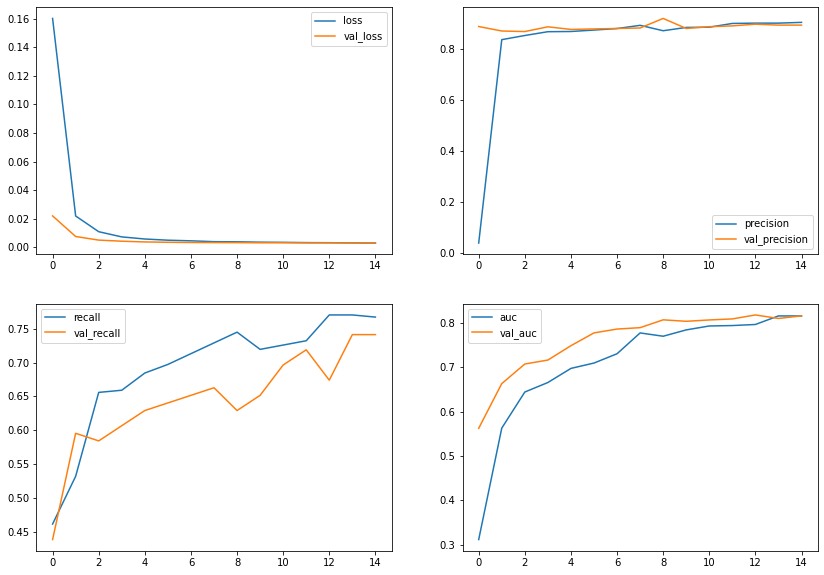

In [81]:
temp = pd.DataFrame(normal_training.history)

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
temp[['loss', 'val_loss']].plot.line(ax=axes[0,0])
temp[['precision', 'val_precision']].plot.line(ax=axes[0,1])
temp[['recall', 'val_recall']].plot.line(ax=axes[1,0])
temp[['auc', 'val_auc']].plot.line(ax=axes[1,1])
plt.show()

In [82]:
result = model_1.evaluate(x_test, y_test)

1603/1603 [==============================] - 2s 1ms/step - loss: 0.0046 - accuracy: 0.9993 - precision: 0.8400 - recall: 0.7079 - auc: 0.7260
